In [1]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import tushare as ts
import datetime
import time
import matplotlib.pyplot as plt
tqdm.pandas(desc="my bars:")
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#settings
current_time = time.strftime("%Y%m%d%H%M", time.localtime())
exp_name = 'strategy_1' #策略名
factor_file_path = 'C:/Users/lenovo/git_intro/华泰场内期权实习/code/strategy_file/%s.csv' %exp_name #策略文件名，保存的三列名称为option_name,trade_time,position
exp_name = exp_name + '_'+ current_time
save_path = 'C:/Users/lenovo/git_intro/华泰场内期权实习/code/%s' %exp_name
os.mkdir(save_path)

In [3]:
#ifind_data_format
pd.read_excel("option_sample_data.xlsx",index_col = 0)

,time,thscode,open,high,low,close,volume,amount,change,changeRatio,sellVolume,buyVolume,openInterest
number,,,,,,,,,,,,,
1,2022-07-18 15:00:00,10003997.SH,0.0434,0.0434,0.0434,0.0434,3.0,1302.0,0.0001,0.2309,0.0,2.0,18734.0
2,2022-07-18 14:55:00,10003997.SH,0.0429,0.0438,0.0429,0.0433,114.0,49355.0,0.0001,0.2315,45.0,67.0,20205.0
3,2022-07-18 14:50:00,10003997.SH,0.0437,0.0439,0.0429,0.0432,560.0,241376.0,-0.0008,-1.8182,175.0,325.0,20158.0
4,2022-07-18 14:45:00,10003997.SH,0.0434,0.0440,0.0434,0.0440,26.0,11346.0,0.0013,3.0445,10.0,0.0,20231.0
5,2022-07-18 14:40:00,10003997.SH,0.0414,0.0427,0.0414,0.0427,71.0,30051.0,0.0009,2.1531,53.0,13.0,20232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15838,2022-06-01 09:45:00,10003984.SH,0.1622,0.1628,0.1617,0.1628,28.0,45487.0,0.0025,1.5596,8.0,18.0,4167.0
15839,2022-06-01 09:40:00,10003984.SH,0.1632,0.1632,0.1603,0.1603,36.0,58330.0,-0.0012,-0.7430,8.0,16.0,4185.0
15840,2022-06-01 09:35:00,10003984.SH,0.1599,0.1615,0.1587,0.1615,31.0,49459.0,0.0027,1.7003,20.0,2.0,4175.0


In [4]:
#strategy data_format
pd.read_csv(factor_file_path,index_col = 0)

,option_name,trade_time,position
0,10003984.SH,2022-06-01 09:35:00,0.006328
1,10003984.SH,2022-06-01 09:40:00,0.181491
2,10003984.SH,2022-06-01 09:45:00,0.127553
3,10003984.SH,2022-06-01 09:50:00,0.011830
4,10003984.SH,2022-06-01 09:55:00,0.072628
...,...,...,...
15835,10003997.SH,2022-07-18 14:40:00,0.031504
15836,10003997.SH,2022-07-18 14:45:00,0.050122
15837,10003997.SH,2022-07-18 14:50:00,0.065181
15838,10003997.SH,2022-07-18 14:55:00,0.008536


In [5]:
#data_reprocessing for ifind data
data_ifind = pd.read_excel("option_sample_data.xlsx",index_col = 0)

data_ifind = data_ifind.groupby('thscode').apply(lambda x:x.sort_values("time"))

data_ifind = pd.DataFrame(columns = data_ifind.columns,data = data_ifind.values)

data_ifind = data_ifind[['thscode','time','close','changeRatio','change','open']]
data_ifind.columns = ['option_name','trade_time','close','ret','position_diff','open']
data_ifind['ret'] = data_ifind['ret']/100
data_ifind['buy_price'] = data_ifind.groupby('option_name').apply(lambda x:(x.close.shift(1) + x.open)/2).values

position_data = pd.read_csv(factor_file_path,index_col = 0)
position_data.trade_time = pd.to_datetime(position_data.trade_time)

bk = pd.merge(position_data,data_ifind,how="left",on=["option_name","trade_time"])
bk.trade_time = bk.trade_time.apply(lambda x:x.strftime('%Y-%m-%d-%H:%M'))
bk['year'] = bk['trade_time'].apply(lambda x:x.split('-')[0])
bk['month'] = bk['trade_time'].apply(lambda x:x.split('-')[1])
bk['day'] = bk['trade_time'].apply(lambda x:x.split('-')[2])
bk['position_diff'] = bk.groupby('option_name')['position'].diff().values
bk['trade_time'] = pd.to_datetime(bk['trade_time'])
bk = bk.dropna()

bk[['close','ret','open']] = bk[['close','ret','open']].applymap(lambda x:float(x))

bk

,option_name,trade_time,position,close,ret,position_diff,open,buy_price,year,month,day
1,10003984.SH,2022-06-01 09:40:00,0.181491,0.1603,-0.007430,0.175163,0.1632,0.16235,2022,06,01
2,10003984.SH,2022-06-01 09:45:00,0.127553,0.1628,0.015596,-0.053938,0.1622,0.16125,2022,06,01
3,10003984.SH,2022-06-01 09:50:00,0.011830,0.1599,-0.017813,-0.115723,0.1614,0.1621,2022,06,01
4,10003984.SH,2022-06-01 09:55:00,0.072628,0.1613,0.008755,0.060798,0.1613,0.1606,2022,06,01
5,10003984.SH,2022-06-01 10:00:00,0.150254,0.1612,-0.000620,0.077626,0.1605,0.1609,2022,06,01
...,...,...,...,...,...,...,...,...,...,...,...
15835,10003997.SH,2022-07-18 14:40:00,0.031504,0.0427,0.021531,-0.134890,0.0414,0.0416,2022,07,18
15836,10003997.SH,2022-07-18 14:45:00,0.050122,0.0440,0.030445,0.018618,0.0434,0.04305,2022,07,18
15837,10003997.SH,2022-07-18 14:50:00,0.065181,0.0432,-0.018182,0.015059,0.0437,0.04385,2022,07,18
15838,10003997.SH,2022-07-18 14:55:00,0.008536,0.0433,0.002315,-0.056645,0.0429,0.04305,2022,07,18


In [6]:
#backtest for the whole period

#output metrics:
#long: average long position
#short: average short position
#ir: information ratio of strategy position and option return
#ic: information coefficient of strategy position and option return
#SR: Sharpe Ratio for the whole strategy period
#Annualized_Ret: Annualized_Return, daily return average * 252
#Annualized_Vol: Annualized_Volatility daily return std * sqrt(252)
#Net_Ret: Return with transaction cost
#Gross_Ret: Return without transaction cost
#maxdd: max drawdown of strategy
#turnover: turnover of strategy
#win: winrate of strategy (whether position and return are in the same direction)

#other detailed caculation method can be seen in the documents
def backtest(df,transaction_cost = 0,initial_capital = 10**6,Period = False):
    time_list = list(df['trade_time'].unique())
    time_list = sorted(time_list)
    backtest = {}
    pnl_tick = []
    ic = []
    pnl_capital = [0,initial_capital]
    tvr_tick = []
    gross_pnl_tick = []
    #print(time_list)
    for t in tqdm(time_list):
        sub_bk = df[df['trade_time']==t]
        sub_bk['transaction_cost'] = transaction_cost*(pnl_capital[-1]*sub_bk["position"] - pnl_capital[-2]*(sub_bk["position"] - \
                                                                sub_bk["position_diff"]))/(10000*sub_bk["buy_price"]*pnl_capital[-1])
        ic.append(sub_bk[['position','ret']].corr().iloc[0,1])
        pnl_capital.append((1+((sub_bk['ret'] - sub_bk['transaction_cost'])*sub_bk['position']).sum())*pnl_capital[-1])
        pnl_tick.append(((sub_bk['ret'] - sub_bk['transaction_cost'])*sub_bk['position']).sum())
        gross_pnl_tick.append((sub_bk['ret']*sub_bk['position']).sum())
        tvr_tick.append((abs((pnl_capital[-1]*sub_bk["position"] - pnl_capital[-2]*(sub_bk["position"] - \
                                                                sub_bk["position_diff"])))/pnl_capital[-1]).sum())
    ir = np.mean(ic)/np.std(ic)
    ic = np.mean(ic)
    temp_df = pd.Series(pnl_tick, index = time_list)
    gross_temp_df = pd.Series(gross_pnl_tick,index = time_list)
    pnl_capital = pd.Series(pnl_capital[2:],index=time_list)
    daily_ret = temp_df.resample('1d').sum()
    annual_ret = daily_ret.mean()*252
    annual_vol = daily_ret.std()*np.sqrt(252)
    pnl = temp_df.cumsum()
    maxdd = (pnl - pnl.cummax()).cummin()

    tvr = pd.Series(tvr_tick,index=time_list).sum()
    win_rate =  df.groupby('trade_time').apply(lambda x:(x['position']*x['ret']>0).sum()/len(x)).mean()


    backtest['long'] = df.loc[bk['position']>0,'position'].mean()
    backtest['short'] = df.loc[bk['position']<0,'position'].mean()
    backtest['ir'] = ir
    backtest['ic'] = ic
    backtest['SR'] = temp_df.mean()/temp_df.std()  #???
    backtest['Annualized_Ret'] = annual_ret
    backtest['Annualized_SR'] = annual_ret/annual_vol
    backtest['Net_Ret'] = temp_df.sum()
    backtest['Gross_Ret'] = gross_temp_df.sum()
    backtest['maxdd'] = maxdd.iloc[-1]
    backtest['tvr'] = tvr
    backtest['win'] = win_rate
    pnl.index = pnl.index.strftime("%Y-%m-%d-%H:%M")
    pnl_capital.index = pnl_capital.index.strftime("%Y-%m-%d-%H:%M")
    maxdd.index = maxdd.index.strftime("%Y-%m-%d-%H:%M")
    res_ts = pd.DataFrame()
    res_ts['cumulative_return'] = pnl
    res_ts['cumulative_capital'] = pnl_capital
    res_ts['maxdd'] = maxdd
    if not Period:
        fig = res_ts.plot(figsize = (10,10),grid = True, subplots = True)
        fig[-1].figure.savefig(os.path.join(save_path, 'result.png'))
        pd.DataFrame(pd.Series(backtest),columns = ["value"]).to_csv(os.path.join(save_path, 'result.csv'))
        res_ts.to_csv(os.path.join(save_path, 'result_TimeSeries.csv'))
    else:
        fig = res_ts.plot(figsize = (10,10),grid = True, subplots = True)
        fig[-1].figure.savefig(os.path.join(save_path, f'{Period}_result.png'))
        res_ts.to_csv(os.path.join(save_path, 'result_TimeSeries.csv'))
    return backtest,res_ts

In [7]:
#backtest by period, method = {"year","month"}
#can produce result grouped by period
def backtest_period(df,transaction_cost = 0,initial_capital = 10**6,method = 'year'):
    backtest_period = {}
    pnl_period = {}
    if method == "year":
        period_list = df[method].unique()
        backtest_res = df.groupby(method).apply(lambda x:backtest(x,transaction_cost,initial_capital,f"{x.trade_time.iloc[0].year}")[0])
    else:
        period_list = (df['year'] + df['month']).unique()
        backtest_res = df.groupby(["year",method]).apply(lambda x:backtest(x,transaction_cost,initial_capital,\
                                                                  f"{x.trade_time.iloc[0].year}_{x.trade_time.iloc[0].month}")[0])
    for period in period_list:
        if method =="year":
            backtest_period[period] = backtest_res[period]
        else:
            backtest_period[(period[:4],period[4:])] = backtest_res[(period[:4],period[4:])]
    pd.DataFrame(backtest_period).T.to_csv(os.path.join(save_path, f'result_{method}.csv'))
    return

100%|█████████████████████████████████████████████████████████████████████████████| 1583/1583 [00:06<00:00, 231.97it/s]


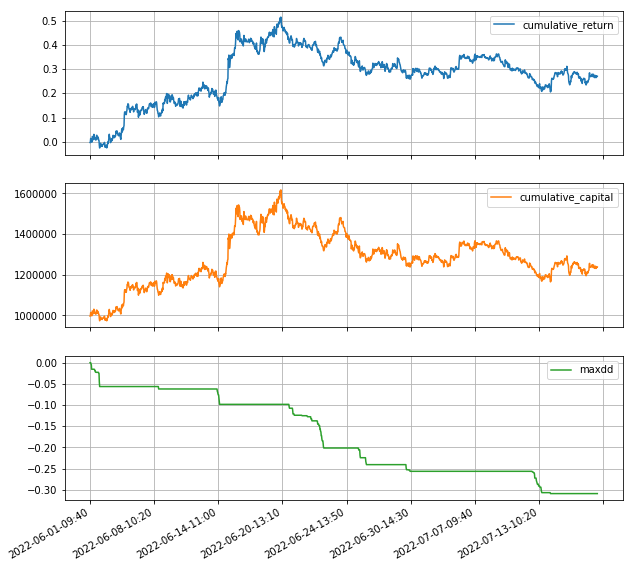

In [9]:
backtest_res,res_ts = backtest(bk,transaction_cost=1.5,initial_capital=10**6)

100%|███████████████████████████████████████████████████████████████████████████████| 576/576 [00:02<00:00, 237.39it/s]


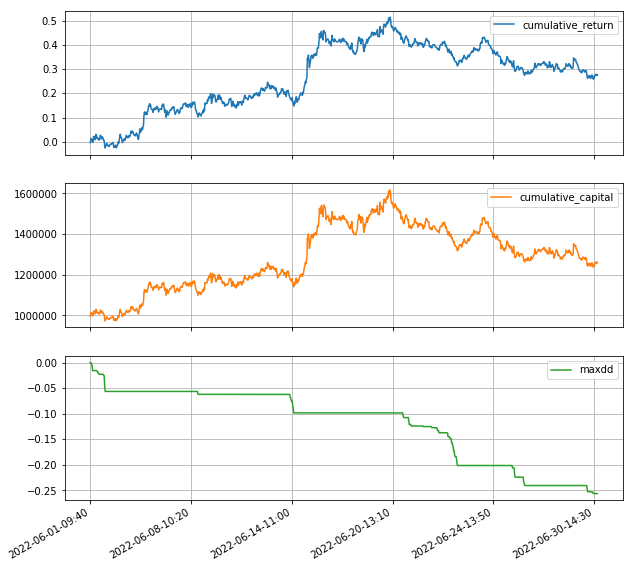

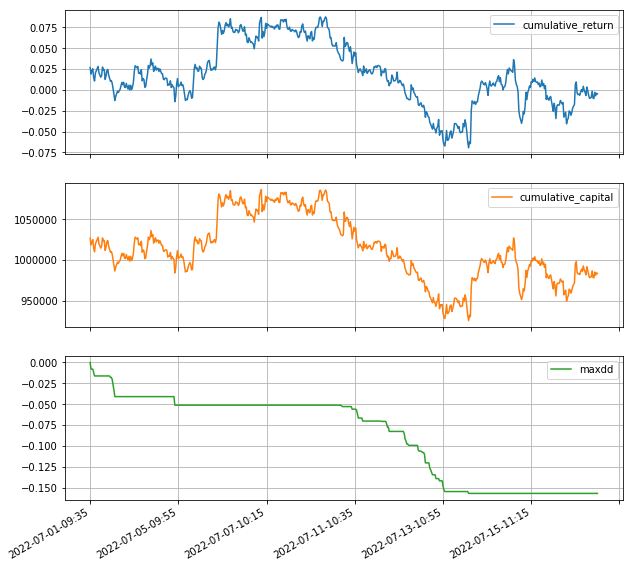

In [10]:
backtest_period(bk,transaction_cost=1.5,initial_capital=10**6,method = "month")